Importing all the needed libraries

In [1]:
from bs4 import BeautifulSoup  
import pandas as pd
import requests
import time 
import re
import random
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from IPython.display import Image, display
from sklearn.model_selection import GridSearchCV
import pydotplus 
from scipy import misc
import os
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import make_scorer

# crawling

In this part, we gather the needed data by performing web crawling

In [2]:
headers = {'User-Agent': 'Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.64 Safari/537.36',
    'Accept-Language': 'en-US, en;q=0.5'}

Sending an http get request

In [3]:
def get_html(Url,Headers):
    response=requests.get(Url,headers=Headers)
    print(response) ####for check
    html=response.text
    return html


Creating a soup object for a given html. 

In [4]:
def load_soup_object(html_name):
    soup_object = BeautifulSoup(html_name, "html.parser")
    return soup_object

Finding all the hotels in a certain page.

In [5]:
def get_hotels(soup_obj):
    hotels = soup_obj.findAll('div', {'data-testid': 'property-card'})
    return hotels

Finding the link for each hotel in order to extract its features later on.

In [6]:
def get_hotel_link(hotels_obj):
    links_obj=[]
    for hotel in hotels_obj:
        links_obj.append(hotel.find("a")["href"])
    return links_obj

In [7]:
def calculate_sleep_duration(min_duration,max_duration):
    sleep_duration = random.uniform(min_duration, max_duration)
    return sleep_duration

Creating a facilities list for each hotel. If a certain feature is found, we append the value '1' to the feature list. If the feature is not found, we append the value '0' to the list.

In [8]:
def Create_facilities_list(Facilities,free_parking,twentyforseven_reception_desk,air_conditioning,room_service,
                          non_smoking_rooms,fitness_center,free_wifi,facilities_for_disabled,airport_shuttle,num_reviewes):
    Facilities_dict={}
    
    if 'Free WiFi' in set(Facilities):
        free_wifi.append(1)
    else:
        free_wifi.append(0)
    if 'Non-smoking rooms' in set(Facilities):
        non_smoking_rooms.append(1)
    else:
        non_smoking_rooms.append(0)
    if 'Airport shuttle' in set(Facilities):
        airport_shuttle.append(1)
    else:
        airport_shuttle.append(0)
    if 'Facilities for disabled guests' in set(Facilities):
        facilities_for_disabled.append(1)
    else:
        facilities_for_disabled.append(0)
    if 'Free parking' in set(Facilities):
        free_parking.append(1)
    else:
        free_parking.append(0)
    if '24-hour front desk' in set(Facilities):
        twentyforseven_reception_desk.append(1)
    else:
        twentyforseven_reception_desk.append(0)
    if 'Fitness center' in set(Facilities):
        fitness_center.append(1)
    else:
        fitness_center.append(0)
    if 'Room service' in set(Facilities):
        room_service.append(1)
    else:
        room_service.append(0)
    if 'Air conditioning' in set(Facilities):
        air_conditioning.append(1)
    else:
        air_conditioning.append(0)
    
    facilities_dict['Free WiFi']=free_wifi
    facilities_dict['Non-smoking rooms']=non_smoking_rooms
    facilities_dict['Airport shuttle']=airport_shuttle
    facilities_dict['Facilities for disabled guests']=facilities_for_disabled
    facilities_dict['Free parking']=free_parking
    facilities_dict['24-hour front desk']=twentyforseven_reception_desk
    facilities_dict['Fitness center']=fitness_center
    facilities_dict['Room service']= room_service
    facilities_dict['Air conditioning']=air_conditioning
    
    return facilities_dict
    
    

In [9]:
def create_hotel_info_lists(soup_obj,name_of_site,ratings,num_reviews):
    hotel_info_dict={}
    
    name=soup.find("h2", {"class": "d2fee87262"}) #name of site
    if name is not None:
        name_of_site.append(name.get_text())
    else:
        name_of_site.append(None)

    rating=soup.find("div",{"class":"d10a6220b4"}) #rating of site
    if rating is not None:
        ratings.append(rating.get_text())
    else:
        ratings.append(None)
    
    review_line=soup.find("div",{"class":"b1e6dd8416 aacd9d0b0a b48795b3df"})## number of site reviews
    if review_line is not None:
        num_review = re.findall(r'\d[\d,]*\d|\d', review_line.get_text()) 
        num_reviews.append(  ''.join(num_review))
    else:
        num_reviews.append(0)  
        
        
    hotel_info_dict['Name of hotel']=name_of_site
    hotel_info_dict['Rating']=ratings
    hotel_info_dict['Number of Reviews']=num_reviews
    return hotel_info_dict

    

In this cell, we are performing web crawling. Initially, we created a dictionary that stores the links to the main pages of each location we are going to explore. Next, we utilize the functions mentioned earlier to extract the required information. To prevent website blocking, we introduce a random delay of 1-5 seconds between each request. Finally, we generate and save individual CSV files for each location, which are then merged into a single CSV file named 'Booking'.

In [ ]:

hotel_places={'London':'https://www.booking.com/searchresults.html?label=gog235jc-1DCAEoggI46AdICVgDaFCIAQGYAQm4ARfIAQzYAQPoAQH4AQKIAgGoAgO4ArDuuaEGwAIB0gIkZmJhYjE4YzAtNDdhMy00MmY1LTk2NWItN2UzOTgyNTk1OWEx2AIE4AIB&aid=397594&checkin=2023-05-06&selected_currency=USD&ss=London&no_rooms=1&dest_id=-2601889&soz=1&group_adults=2&sb=1&src_elem=sb&sb_travel_purpose=leisure&ssne=London&src=searchresults&checkout=2023-05-07&dest_type=city&group_children=0&ssne_untouched=London&ltfd=6%3A1%3A5-2023%3A&lang_changed=1&lang=en-us&prefer_site_type=mdot',
              'Paris':'https://www.booking.com/searchresults.html?ss=Paris&ssne=Paris&ssne_untouched=Paris&efdco=1&label=gog235jc-1DCAEoggI46AdICVgDaFCIAQGYAQm4ARfIAQzYAQPoAQH4AQKIAgGoAgO4ArDuuaEGwAIB0gIkZmJhYjE4YzAtNDdhMy00MmY1LTk2NWItN2UzOTgyNTk1OWEx2AIE4AIB&aid=397594&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=-1456928&dest_type=city&checkin=2023-05-21&checkout=2023-05-22&group_adults=2&no_rooms=1&group_children=0&prefer_site_type=mdot',
              'Florida':'https://www.booking.com/searchresults.en-us.html?ss=Florida&group_adults=2&group_children=0&no_rooms=1&sb_travel_purpose=leisure&ssne=Paris&ssne_untouched=Paris&sb_changed_dest=1&label=gog235jc-1DCAEoggI46AdICVgDaFCIAQGYAQm4ARfIAQzYAQPoAQH4AQKIAgGoAgO4ArDuuaEGwAIB0gIkZmJhYjE4YzAtNDdhMy00MmY1LTk2NWItN2UzOTgyNTk1OWEx2AIE4AIB&aid=397594&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=1136&dest_type=region&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=f5ea4c4a1ce200ae&ac_meta=GhBmNWVhNGM0YTFjZTIwMGFlIAAoATICZW46B0Zsb3JpZGFAAEoAUAA%3D&checkin=2023-05-21&checkout=2023-05-22&prefer_site_type=mdot',
              'Spain':'https://www.booking.com/searchresults.en-us.html?ss=Spain&group_adults=2&group_children=0&no_rooms=1&sb_travel_purpose=leisure&ssne=Florida&ssne_untouched=Florida&sb_changed_dest=1&label=gog235jc-1DCAEoggI46AdICVgDaFCIAQGYAQm4ARfIAQzYAQPoAQH4AQKIAgGoAgO4ArDuuaEGwAIB0gIkZmJhYjE4YzAtNDdhMy00MmY1LTk2NWItN2UzOTgyNTk1OWEx2AIE4AIB&aid=397594&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=197&dest_type=country&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=257b4c6183e80203&ac_meta=GhAyNTdiNGM2MTgzZTgwMjAzIAAoATICZW46BVNwYWluQABKAFAA&checkin=2023-05-21&checkout=2023-05-22&prefer_site_type=mdot',
              'Israel':'https://www.booking.com/searchresults.en-us.html?ss=Israel&group_adults=2&group_children=0&no_rooms=1&sb_travel_purpose=leisure&ssne=Spain&ssne_untouched=Spain&sb_changed_dest=1&label=gog235jc-1DCAEoggI46AdICVgDaFCIAQGYAQm4ARfIAQzYAQPoAQH4AQKIAgGoAgO4ArDuuaEGwAIB0gIkZmJhYjE4YzAtNDdhMy00MmY1LTk2NWItN2UzOTgyNTk1OWEx2AIE4AIB&aid=397594&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=103&dest_type=country&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=8b1e4c7962c5013e&ac_meta=GhA4YjFlNGM3OTYyYzUwMTNlIAAoATICZW46BklzcmFlbEAASgBQAA%3D%3D&checkin=2023-05-21&checkout=2023-05-22&prefer_site_type=mdot'}

i=0
df=pd.DataFrame()

for place in hotel_places:
    hotel_info_dict={}
    facilities_dict={}
    Name_of_site=[]
    Ratings=[]
    Num_reviews=[]
    Free_parking=[]
    Twentyforseven_reception_desk=[]
    Air_conditioning=[]
    Room_service=[]
    Non_smoking_rooms=[]
    Fitness_center=[]
    Free_wifi=[]
    Facilities_for_disabled=[]
    Airport_shuttle=[]
    Num_reviewes=[]
    next_url=hotel_places[place]
    for num in range(1,35):
        print(next_url)
        main_html=get_html(next_url,headers)
        soup_obj=load_soup_object(main_html)
        hotels = get_hotels(soup_obj)
        links= get_hotel_link(hotels)
        for link in links:
            facilities=[]
            html=get_html(link,headers)
            ###wait a random time between the requests
            sleep_duration = calculate_sleep_duration(1,5)
            time.sleep(sleep_duration)
            soup=load_soup_object(html)
            hotel_info_dict.update(create_hotel_info_lists(soup,Name_of_site,Ratings,Num_reviews))
            features=soup.find_all("span",{"class":"db312485ba"})
            for feature in features:
                facilities.append(feature.text)
            facilities_dict.update(Create_facilities_list(facilities,Free_parking,Twentyforseven_reception_desk,Air_conditioning,
                                                  Room_service,Non_smoking_rooms,Fitness_center,Free_wifi,Facilities_for_disabled,
                                                  Airport_shuttle,Num_reviewes))
        if num==34:
            df = pd.DataFrame({"Name of hotel":hotel_info_dict['Name of hotel'],"Rating": hotel_info_dict['Rating'],
                   "Number of Reviews":hotel_info_dict['Number of Reviews'],
                   "Air conditioning":facilities_dict['Air conditioning'],"Room service":facilities_dict['Room service'],
                   "Non-smoking rooms":facilities_dict['Non-smoking rooms'], 
                   "Fitness_center":facilities_dict['Fitness center'], "Free Wi-fi":facilities_dict['Free WiFi'],
                   "24/7 reception desk":facilities_dict['24-hour front desk'], 
                   "Facilities for disabled":facilities_dict['Facilities for disabled guests'],
                   "Transport service from/to airport":facilities_dict['Airport shuttle'],})
            file_name = f"{place}.csv"
            df.to_csv(fr'C:\Users\ליהי\Desktop\{file_name}')
            break
        next_url=soup_obj.find('a',{'title':'Next page'})['href']
    
merged_df = pd.concat([pd.read_csv(r"C:\Users\ליהי\Desktop\Paris.csv"),pd.read_csv(r"C:\Users\ליהי\Desktop\London.csv"),pd.read_csv(r"C:\Users\ליהי\Desktop\Israel.csv"),
    pd.read_csv(r"C:\Users\ליהי\Desktop\Florida.csv"),pd.read_csv(r"C:\Users\ליהי\Desktop\Spain.csv")])
# Save the merged DataFrame to a CSV file
merged_df.to_csv(r'C:\Users\ליהי\Desktop\Booking.csv')


After obtaining our CSV files, we realized that we had overlooked the absence of location information for each hotel. To address this, we created a separate DataFrame for each CSV file and included a column named 'Location'. Then, we merged all the individual DataFrames into a single DataFrame named 'booking_df'.

In [10]:
paris = pd.read_csv(r"C:\Users\ליהי\Desktop\Paris.csv",index_col=False)
paris['Location']='Paris'
london = pd.read_csv(r"C:\Users\ליהי\Desktop\London.csv",index_col=False)
london['Location']='London'
israel = pd.read_csv(r"C:\Users\ליהי\Desktop\Israel.csv",index_col=False)
israel['Location']='Israel'
florida = pd.read_csv(r"C:\Users\ליהי\Desktop\Florida.csv",index_col=False)
florida['Location']='Florida'
spain = pd.read_csv(r"C:\Users\ליהי\Desktop\Spain.csv",index_col=False)
spain['Location']='Spain'

booking_df=pd.concat([paris,london,israel,florida,spain],ignore_index=True)
booking_df

,Name of hotel,Rating,Number of Reviews,Air conditioning,Room service,Non-smoking rooms,Fitness center,Free Wi-fi,24/7 reception desk,Facilities for disabled,Transport service from/to airport,Location
0,COZY ROOM WITH A WONDERFUL VIEW FROM THE BALCONY,NaN,9438,1,0,0,0,1,0,0,0,Paris
1,Suite de luxe gayou,NaN,0,1,0,0,0,1,0,0,0,Paris
2,ibis Budget Paris Nord 18ème,7.0,"2,575",1,0,1,0,1,1,1,0,Paris
3,loft canal st martin,NaN,0,0,0,0,0,1,0,0,0,Paris
4,HotelF1 Paris Saint Ouen Marché Aux Puces,6.3,"10,306",0,0,1,0,1,1,1,0,Paris
...,...,...,...,...,...,...,...,...,...,...,...,...
5095,Parque Florida,9.3,"2,298",1,0,1,0,1,0,1,0,Spain
5096,Hotel Sierra de Araceli Lucena,8.4,483,1,0,0,0,1,1,0,0,Spain
5097,Palación de Toñanes,9.1,469,0,1,1,0,1,1,0,0,Spain
5098,Hostal Santa Gemma,8.2,880,0,0,1,0,1,0,0,0,Spain


# Data preparation
In the data preparation phase, we performed several operations to ensure the data is ready for analysis. 
This included handling missing data,removing duplicated rows, and converting continuous variables into binary variables.

In [11]:
booking_df.drop_duplicates(keep='first',inplace=True)
booking_df

,Name of hotel,Rating,Number of Reviews,Air conditioning,Room service,Non-smoking rooms,Fitness center,Free Wi-fi,24/7 reception desk,Facilities for disabled,Transport service from/to airport,Location
0,COZY ROOM WITH A WONDERFUL VIEW FROM THE BALCONY,NaN,9438,1,0,0,0,1,0,0,0,Paris
1,Suite de luxe gayou,NaN,0,1,0,0,0,1,0,0,0,Paris
2,ibis Budget Paris Nord 18ème,7.0,"2,575",1,0,1,0,1,1,1,0,Paris
3,loft canal st martin,NaN,0,0,0,0,0,1,0,0,0,Paris
4,HotelF1 Paris Saint Ouen Marché Aux Puces,6.3,"10,306",0,0,1,0,1,1,1,0,Paris
...,...,...,...,...,...,...,...,...,...,...,...,...
5095,Parque Florida,9.3,"2,298",1,0,1,0,1,0,1,0,Spain
5096,Hotel Sierra de Araceli Lucena,8.4,483,1,0,0,0,1,1,0,0,Spain
5097,Palación de Toñanes,9.1,469,0,1,1,0,1,1,0,0,Spain
5098,Hostal Santa Gemma,8.2,880,0,0,1,0,1,0,0,0,Spain


After obtaining our DataFrame, the next step is to handle the data. We have already removed duplicated rows, and now we will focus on handling None values. Firstly, we will check if any None values exist in the DataFrame, and if so, we will identify which columns contain them.

In [12]:
columns_with_none = booking_df.columns[booking_df.isnull().any()]
for column in columns_with_none:
    print(column)

Rating
Number of Reviews


In this cell, we are handling the None values in the 'Number of Reviews' column.Firstly, we convert the values in the 'Number of Reviews' column into numeric values. This conversion ensures that the values are in a suitable numerical format for further analysis.
Next, we calculate the mean of the 'Number of Reviews' for each location. By grouping the data based on the location, we can determine the average number of reviews specific to each location.
Finally, we replace the None values in the 'Number of Reviews' column with the mean values that correspond to the respective location. This substitution helps to fill in missing data with meaningful information based on the average reviews for each location. 

In [13]:
booking_df['Number of Reviews'] = pd.to_numeric(booking_df['Number of Reviews'], errors='coerce')
mean_reviews_by_location = booking_df.groupby('Location')['Number of Reviews'].mean()
booking_df['Number of Reviews'] = booking_df.groupby('Location')['Number of Reviews'].transform(lambda x: x.fillna(x.mean()))
booking_df

,Name of hotel,Rating,Number of Reviews,Air conditioning,Room service,Non-smoking rooms,Fitness center,Free Wi-fi,24/7 reception desk,Facilities for disabled,Transport service from/to airport,Location
0,COZY ROOM WITH A WONDERFUL VIEW FROM THE BALCONY,NaN,9438.000000,1,0,0,0,1,0,0,0,Paris
1,Suite de luxe gayou,NaN,0.000000,1,0,0,0,1,0,0,0,Paris
2,ibis Budget Paris Nord 18ème,7.0,503.723150,1,0,1,0,1,1,1,0,Paris
3,loft canal st martin,NaN,0.000000,0,0,0,0,1,0,0,0,Paris
4,HotelF1 Paris Saint Ouen Marché Aux Puces,6.3,503.723150,0,0,1,0,1,1,1,0,Paris
...,...,...,...,...,...,...,...,...,...,...,...,...
5095,Parque Florida,9.3,422.180247,1,0,1,0,1,0,1,0,Spain
5096,Hotel Sierra de Araceli Lucena,8.4,483.000000,1,0,0,0,1,1,0,0,Spain
5097,Palación de Toñanes,9.1,469.000000,0,1,1,0,1,1,0,0,Spain
5098,Hostal Santa Gemma,8.2,880.000000,0,0,1,0,1,0,0,0,Spain


In this cell, our focus is on handling the None values in the 'Rating' column.
We begin by calculating the mean of the 'Rating' for each location. By grouping the data based on the location, we can determine the average rating specific to each location. This allows us to capture the overall rating trend for different locations.
Next, we proceed to replace the None values in the 'Rating' column, similar to what we did for the 'Number of Reviews' column.

In [14]:
mean_rating_by_location = booking_df.groupby('Location')['Rating'].mean()
booking_df['Rating'] = booking_df.groupby('Location')['Rating'].transform(lambda x: x.fillna(x.mean()))
booking_df

,Name of hotel,Rating,Number of Reviews,Air conditioning,Room service,Non-smoking rooms,Fitness center,Free Wi-fi,24/7 reception desk,Facilities for disabled,Transport service from/to airport,Location
0,COZY ROOM WITH A WONDERFUL VIEW FROM THE BALCONY,8.072122,9438.000000,1,0,0,0,1,0,0,0,Paris
1,Suite de luxe gayou,8.072122,0.000000,1,0,0,0,1,0,0,0,Paris
2,ibis Budget Paris Nord 18ème,7.000000,503.723150,1,0,1,0,1,1,1,0,Paris
3,loft canal st martin,8.072122,0.000000,0,0,0,0,1,0,0,0,Paris
4,HotelF1 Paris Saint Ouen Marché Aux Puces,6.300000,503.723150,0,0,1,0,1,1,1,0,Paris
...,...,...,...,...,...,...,...,...,...,...,...,...
5095,Parque Florida,9.300000,422.180247,1,0,1,0,1,0,1,0,Spain
5096,Hotel Sierra de Araceli Lucena,8.400000,483.000000,1,0,0,0,1,1,0,0,Spain
5097,Palación de Toñanes,9.100000,469.000000,0,1,1,0,1,1,0,0,Spain
5098,Hostal Santa Gemma,8.200000,880.000000,0,0,1,0,1,0,0,0,Spain


In our DataFrame, we have two columns with continuous values and eight columns with categorical values. Our approach is to transform the continuous value columns into categorical columns. To achieve this, we utilize the mean values calculated earlier for each location in the 'Rating' and 'Number of Reviews' columns.

For each value in these continuous columns, if the value is less than the corresponding mean, it will be assigned a value of 0. Conversely, if the value is greater than or equal to the mean, it will be assigned a value of 1.

By utilizing this approach, we transform the continuous value columns into categorical columns based on the mean values, allowing us to categorize the data and analyze it effectively.

In [15]:
for index, row in booking_df.iterrows():
    location = row['Location']
    mean_reviews = mean_reviews_by_location[location]
    mean_rating = mean_rating_by_location[location]
    if row['Number of Reviews'] >= mean_reviews:
        booking_df.at[index, 'Number of Reviews'] = 1
    else:
        booking_df.at[index, 'Number of Reviews'] = 0
    
    if row['Rating'] >= mean_rating:
        booking_df.at[index, 'Rating'] = 1
    else:
        booking_df.at[index, 'Rating'] = 0
        
booking_df

,Name of hotel,Rating,Number of Reviews,Air conditioning,Room service,Non-smoking rooms,Fitness center,Free Wi-fi,24/7 reception desk,Facilities for disabled,Transport service from/to airport,Location
0,COZY ROOM WITH A WONDERFUL VIEW FROM THE BALCONY,1.0,1.0,1,0,0,0,1,0,0,0,Paris
1,Suite de luxe gayou,1.0,0.0,1,0,0,0,1,0,0,0,Paris
2,ibis Budget Paris Nord 18ème,0.0,1.0,1,0,1,0,1,1,1,0,Paris
3,loft canal st martin,1.0,0.0,0,0,0,0,1,0,0,0,Paris
4,HotelF1 Paris Saint Ouen Marché Aux Puces,0.0,1.0,0,0,1,0,1,1,1,0,Paris
...,...,...,...,...,...,...,...,...,...,...,...,...
5095,Parque Florida,1.0,1.0,1,0,1,0,1,0,1,0,Spain
5096,Hotel Sierra de Araceli Lucena,0.0,1.0,1,0,0,0,1,1,0,0,Spain
5097,Palación de Toñanes,1.0,1.0,0,1,1,0,1,1,0,0,Spain
5098,Hostal Santa Gemma,0.0,1.0,0,0,1,0,1,0,0,0,Spain


When working with binary data, such as data that consists of only 0s and 1s, there is no need to handle or remove outliers.
Also, all the data in our dataset was gathered in the same manner. In such cases, outliers are less likely to occur since there is no significant variation within the data collection process. Thus, we will not handle outliers in our dataset.

# EDA & Visualization

The visualization component of our project plays a crucial role in providing meaningful insights and understanding the patterns in our data.
Through effective visualizations, we aim to present complex information in a clear and intuitive manner.

Here we compare the counts of recommended and not recommended vacation sites based on different features.

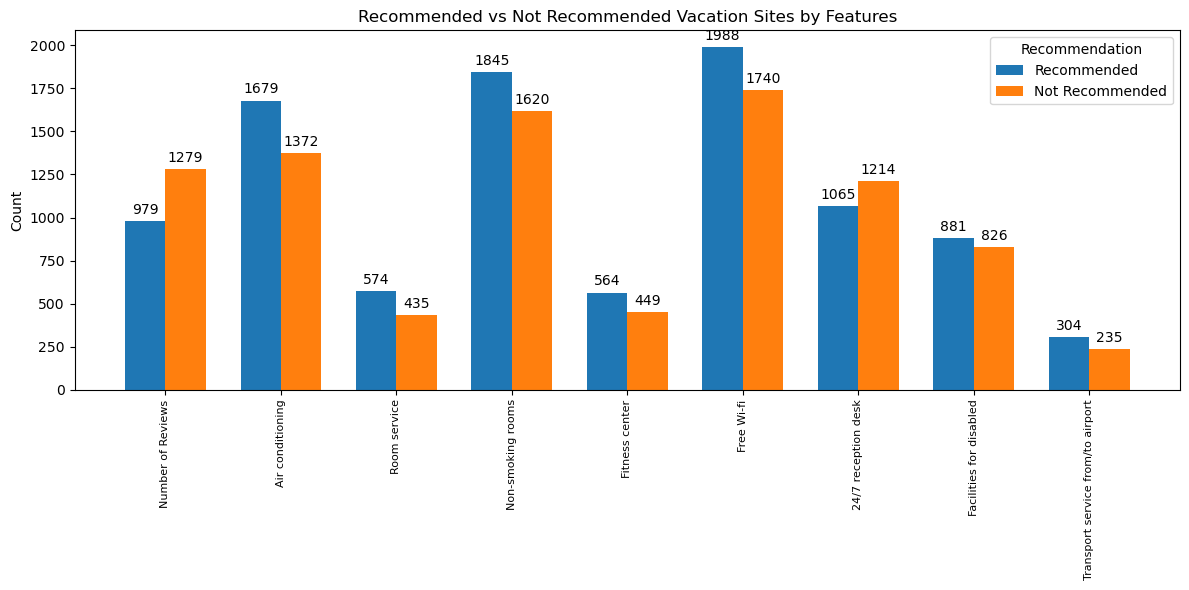

In [16]:
recommended_sites = booking_df[booking_df['Rating'] == 1]
not_recommended_sites = booking_df[booking_df['Rating'] == 0]

feature_columns = ['Number of Reviews', 'Air conditioning', 'Room service', 'Non-smoking rooms', 'Fitness center', 'Free Wi-fi', '24/7 reception desk', 'Facilities for disabled', 'Transport service from/to airport']

recommended_counts = recommended_sites[feature_columns].eq(1).sum()
not_recommended_counts = not_recommended_sites[feature_columns].eq(1).sum()

x = np.arange(len(feature_columns))

bar_width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - bar_width/2, recommended_counts, bar_width, label='Recommended')
rects2 = ax.bar(x + bar_width/2, not_recommended_counts, bar_width, label='Not Recommended')

ax.set_xticks(x)
ax.set_xticklabels(feature_columns, rotation=90, ha='center', fontsize=8)

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom')

ax.set_ylabel("Count")

ax.set_title("Recommended vs Not Recommended Vacation Sites by Features")

ax.legend(title='Recommendation')

plt.tight_layout()
plt.show()


Based on the bar plot shown above, it is evident that, for all features except "Number of Reviews" and "24/7 Reception Desk", the number of recommended sites with a particular feature is greater than the number of not recommended sites with the same feature.

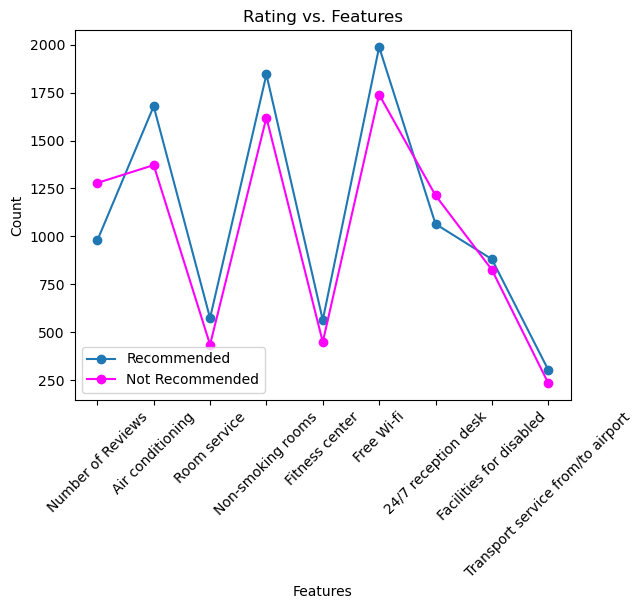

In [17]:
feature_counts = pd.concat([recommended_counts, not_recommended_counts], axis=1)
feature_counts.columns = ['Recommended', 'Not Recommended']

x = feature_columns

plt.plot(x, feature_counts['Recommended'], marker='o', label='Recommended')
plt.plot(x, feature_counts['Not Recommended'], marker='o', label='Not Recommended',color='magenta')

plt.title('Rating vs. Features')
plt.xlabel('Features')
plt.ylabel('Count')

plt.legend()

plt.xticks(rotation=45)

plt.show()

This code analyzes the relationship between different features and the count of recommended and not recommended ratings. It plots a line graph showing the count of recommended ratings and the count of not recommended ratings for each feature. It is evident that certain features have a significant influence on the ratings, either positively or negatively. The features that stand out as having the most notable impact on the ratings are air conditioning, non-smoking rooms, and free WiFi. These features seem to play a crucial role in determining whether a hotel receives good or bad ratings.

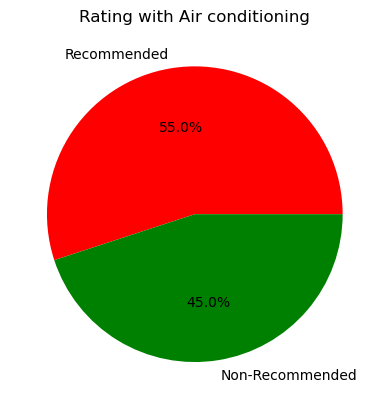

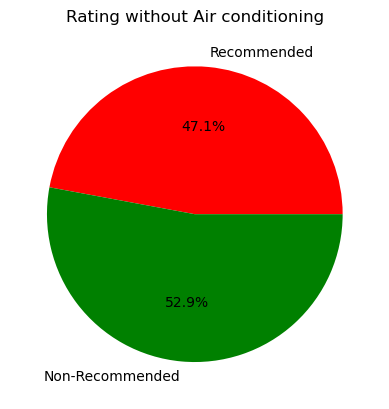

In [18]:
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2

colors = ['red','green']

with_air_conditioning = booking_df[booking_df['Air conditioning'] == 1]

recommended_count1 = with_air_conditioning['Rating'].value_counts()[1]
non_recommended_count1 = with_air_conditioning['Rating'].value_counts()[0]

sizes1 = [recommended_count1, non_recommended_count1]
labels1 = ['Recommended', 'Non-Recommended']

plt1.pie(sizes1, labels=labels1, autopct='%1.1f%%',colors=colors)
plt1.title('Rating with Air conditioning')

plt1.show()

without_air_conditioning = booking_df[booking_df['Air conditioning'] == 0]

recommended_count2 = without_air_conditioning['Rating'].value_counts()[1]
non_recommended_count2 = without_air_conditioning['Rating'].value_counts()[0]

sizes2 = [recommended_count2, non_recommended_count2]
labels2 = ['Recommended', 'Non-Recommended']

plt2.pie(sizes2, labels=labels2, autopct='%1.1f%%',colors=colors)
plt2.title('Rating without Air conditioning')

plt2.show()


This code analyzes the ratings of hotels with and without air conditioning and visualizes the distribution of recommended and non-recommended ratings using pie charts. The first chart shows the popularity of hotels with air conditioning, and the second chart shows the popularity for hotels without air conditioning. Upon analyzing the data, it is evident that there is an 8% difference in recommendations when the hotel has air conditioning.

# Machine- learning models and advanced analytics

In this part, we focus on employing machine learning models to analyze and make predictions on our data.
We utilize five different models: decision tree, random forest, SVM, AdaBoost, and XGBoost.
These models are powerful tools that can help us gain valuable insights from our binary dataset and make accurate predictions.

This function splits a subset of the booking dataset, given by the features, into train and test sets.

In [19]:
def splitData(features):
    booking_predictors = booking_df[features].values
    booking_labels = booking_df["Rating"].values
    XTrain, XTest, yTrain, yTest = train_test_split(booking_predictors, booking_labels, random_state=1, test_size=0.5)
    
    return XTrain, XTest, yTrain, yTest

This function is used for visualizing decision trees

In [20]:
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\bin'

def renderTree(my_tree, features):
    # hacky solution of writing to files and reading again
    # necessary due to library bugs
    filename = "temp.dot"
    with open(filename, 'w') as f:
        f = tree.export_graphviz(my_tree, 
                                 out_file=f, 
                                 feature_names=features, 
                                 class_names=["Recommended", "Not Recommended"],  
                                 filled=True, 
                                 rounded=True,
                                 special_characters=True)
  
    dot_data = ""
    with open(filename, 'r') as f:
        dot_data = f.read()

    graph = pydotplus.graph_from_dot_data(dot_data)
    image_name = "DecisionTree.png"
    graph.write_png(image_name)  
    display(Image(filename=image_name))

This function is used to visualize the importance of features in a machine learning model

In [21]:
def plot_feature_importances(features, importances):
    feature_importances_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

    print(feature_importances_df)

    plt.figure(figsize=(10, 6))
    plt.bar(feature_importances_df['Feature'], feature_importances_df['Importance'])
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importances')
    plt.xticks(rotation=90)
    plt.show()

This function is used to evaluate the performance of a decision tree classifier on both the training and test datasets.Then, it calculates the accuracy score and F1 score on both the training and test datasets.

In [23]:
def analyze_decision_tree(decision_tree,XTrain, yTrain, XTest, yTest):
    
    y_pred_train = decision_tree.predict(XTrain)
    print('Accuracy on training data =', metrics.accuracy_score(y_true=yTrain, y_pred=y_pred_train))
    print('F1 score on training data =', f1_score(y_true=yTrain, y_pred=y_pred_train))

    y_pred = decision_tree.predict(XTest)
    print('Accuracy on test data =', metrics.accuracy_score(y_true=yTest, y_pred=y_pred))
    print('F1 score on test data =', f1_score(y_true=yTest, y_pred=y_pred))

This function is used to evaluate the performance of a random forest classifier on both the training and test datasets.Then, it calculates the accuracy score and F1 score on both the training and test datasets.

In [24]:
def analyze_random_forest(trained_forest,XTrain, yTrain, XTest, yTest):
    
    y_pred_train = trained_forest.predict(XTrain)
    print('Accuracy on training data =', metrics.accuracy_score(y_true=yTrain, y_pred=y_pred_train))
    print('F1 score on training data =', f1_score(y_true=yTrain, y_pred=y_pred_train))

    y_pred = trained_forest.predict(XTest)
    print('Accuracy on test data =', metrics.accuracy_score(y_true=yTest, y_pred=y_pred))
    print('F1 score on test data =', f1_score(y_true=yTest, y_pred=y_pred))

Splitting the data for further operations

In [25]:
all_features = ['Air conditioning', 'Room service', 'Non-smoking rooms', 'Fitness center', 'Free Wi-fi', '24/7 reception desk', 'Facilities for disabled', 'Transport service from/to airport', 'Number of Reviews']
XTrain, XTest, yTrain, yTest = splitData(all_features)

# Decision trees and random forests
Decision trees and random forests handle binary features and can effectively capture complex interactions between them. They can handle both categorical and numerical variables and provide interpretable results.

Here we are training the decision tree classifier, evaluating its performance on both the training and test datasets, and visualizing the resulting decision tree. The training set is the features of a hotel, and the label is what we are trying to predict- the rating of a hotel. 

Accuracy on training data = 0.6585489599188229
F1 score on training data = 0.6811937470393179
Accuracy on test data = 0.6186612576064908
F1 score on test data = 0.6391554702495201


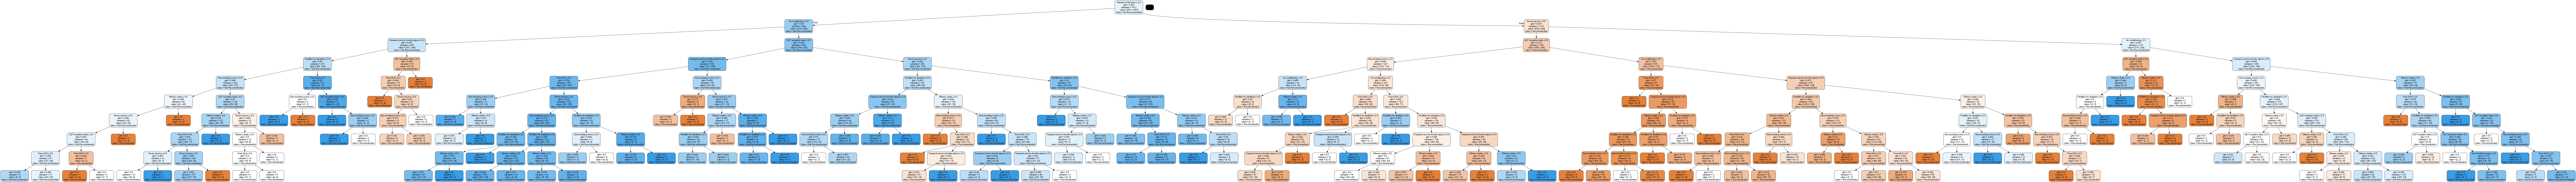

In [26]:
decisionTree = tree.DecisionTreeClassifier()
decisionTree.fit(XTrain, yTrain)
analyze_decision_tree(decisionTree, XTrain, yTrain, XTest, yTest)
renderTree(decisionTree,all_features)

We observe that the F1 score is higher than the accuracy score for both the training and test data. However, the achieved scores are not satisfactory. To improve the performance on both sets, we will focus on identifying the most important features that influence the hotel rating. From the plot below, it is evident that the 'Number of Reviews' feature holds significantly more importance compared to other features.

                             Feature  Importance
8                  Number of Reviews    0.336754
0                   Air conditioning    0.108573
1                       Room service    0.108138
5                24/7 reception desk    0.091683
2                  Non-smoking rooms    0.082109
7  Transport service from/to airport    0.081667
6            Facilities for disabled    0.075331
3                     Fitness center    0.072148
4                         Free Wi-fi    0.043597


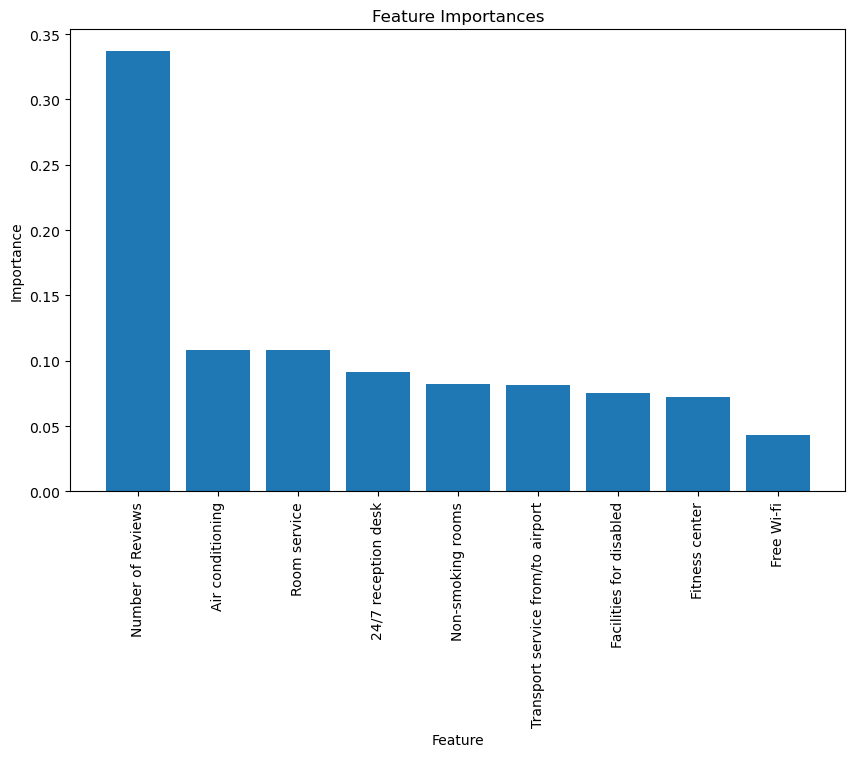

In [27]:
decisionTree = tree.DecisionTreeClassifier()
decisionTree.fit(XTrain, yTrain)
importances = decisionTree.feature_importances_
plot_feature_importances(all_features, importances)


We will try getting a higher score by taking into consideration only the top 4 important features as we have found in the plot above. 

Accuracy on training data = 0.6336884830035515
F1 score on training data = 0.6771019677996422
Accuracy on test data = 0.6110547667342799
F1 score on test data = 0.6530981456354592


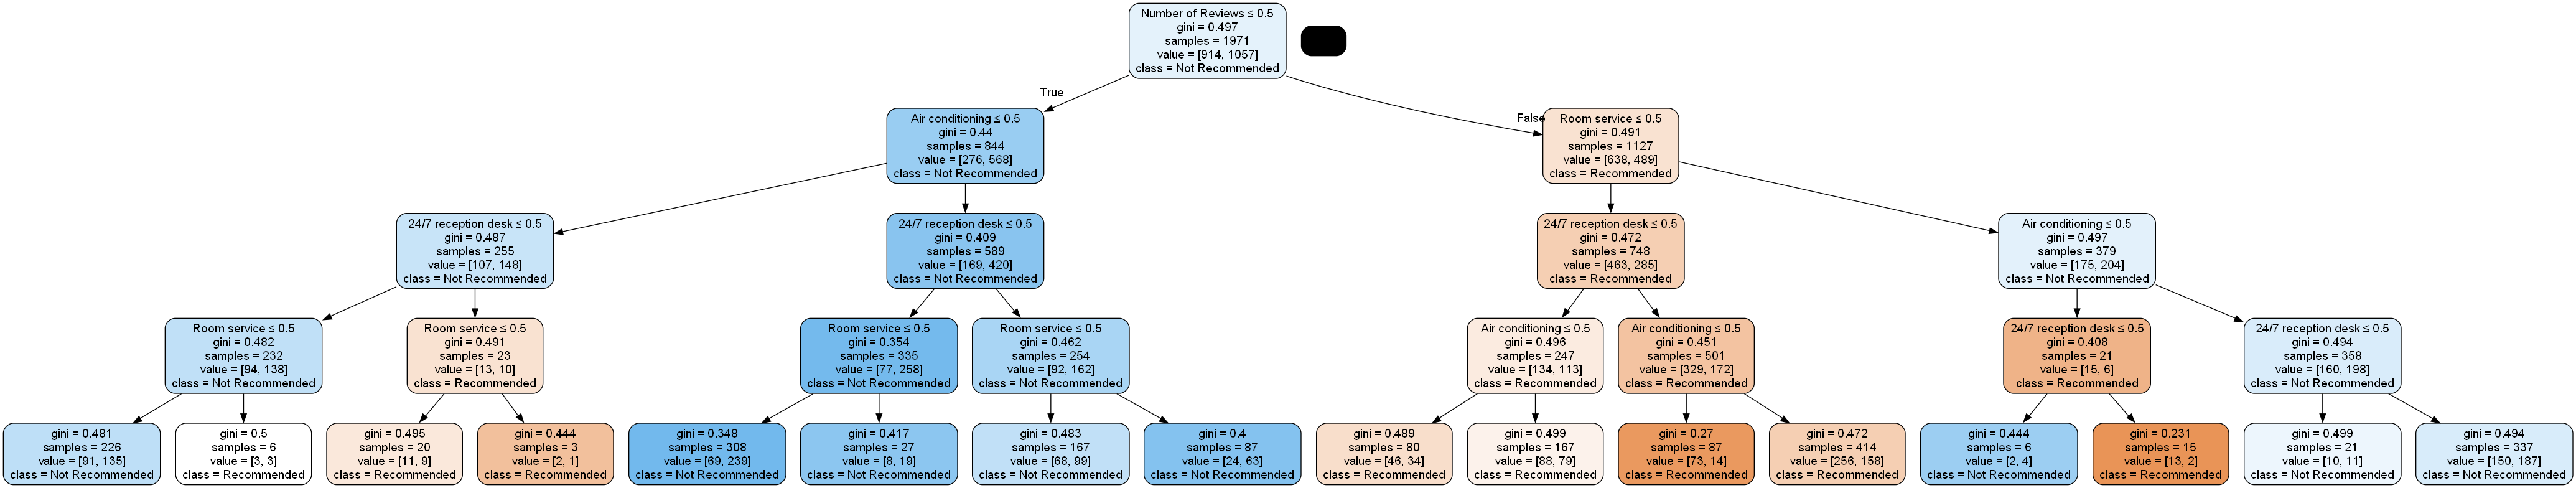

In [28]:
decisionTree = tree.DecisionTreeClassifier()
all_features = ['Number of Reviews', 'Air conditioning', 'Room service', '24/7 reception desk']
XTrain, XTest, yTrain, yTest = splitData(all_features)
decisionTree = decisionTree.fit(XTrain, yTrain)
analyze_decision_tree(decisionTree, XTrain, yTrain, XTest, yTest)
renderTree(decisionTree,all_features)

We can notice that  the initial split from the root is determined by selecting the feature that provides the most valuable information for making predictions. This choice is consistent with the feature importance plot we examined earlier, which highlights the relative significance of different features in the model's decision-making process.

We can observe that the accuracy score is lower on both the training and test data, while the F1 score is higher on the test data. However, we are still not satisfied. Let's explore another model - the random forest algorithm - to see if it can improve the performance.

In [29]:
all_features = ['Air conditioning', 'Room service', 'Non-smoking rooms', 'Fitness center', 'Free Wi-fi', '24/7 reception desk', 'Facilities for disabled', 'Transport service from/to airport', 'Number of Reviews']
XTrain, XTest, yTrain, yTest = splitData(all_features)

In [33]:
forest = RandomForestClassifier(bootstrap=True, n_estimators=300, random_state=0)
trained_forest = forest.fit(XTrain, yTrain)
analyze_random_forest(trained_forest,XTrain, yTrain, XTest, yTest)

Accuracy on training data = 0.6585489599188229
F1 score on training data = 0.6961625282167043
Accuracy on test data = 0.6237322515212982
F1 score on test data = 0.6564814814814816


The results we obtained from the random forest model are higher than the results from the decision tree model on the training and test data, as indicated by both the accuracy and F1 score.
However, it is worth exploring different values for the n_estimators parameter to investigate if a different number of estimators can further improve the scores. 

In [34]:
def analyze_random_forest_with_best_n(XTrain, yTrain, XTest, yTest):
    
    forest = RandomForestClassifier(random_state=0)
    param_grid = {'n_estimators': [100, 200, 300, 400, 500],'max_depth': [3, 4, 5]}

    grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5)
    grid_search.fit(XTrain, yTrain)

    best_forest = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print('Best hyperparameters:', best_params)

    y_pred_train = best_forest.predict(XTrain)
    print('Accuracy on training data:', metrics.accuracy_score(y_true=yTrain, y_pred=y_pred_train))
    print('F1 score on training data:', f1_score(y_true=yTrain, y_pred=y_pred_train))

    y_pred = best_forest.predict(XTest)
    print('Accuracy on test data:', metrics.accuracy_score(y_true=yTest, y_pred=y_pred))
    print('F1 score on test data:', f1_score(y_true=yTest, y_pred=y_pred))

In [36]:
analyze_random_forest_with_best_n(XTrain, yTrain, XTest, yTest)

Best hyperparameters: {'max_depth': 4, 'n_estimators': 200}
Accuracy on training data: 0.6423135464231354
F1 score on training data: 0.6785225718194254
Accuracy on test data: 0.6166328600405679
F1 score on test data: 0.6512915129151291


Apparently, our assumption was correct as the best value for n_estimators is found to be 200. 
However, the scores obtained for the Random Forest model are still very similar. 
Lets employ an alternative machine learning model.

# SVM
Support Vector Machines are particularly useful for binary classification tasks as they aim to find the optimal hyperplane that separates the two classes.
They can handle high-dimensional data like our data and nonlinear decision boundaries.
We will try getting higher scores using SVM.

In [37]:
def analyze_svm(XTrain, yTrain, XTest, yTest):
    classifier = svm.SVC(kernel='rbf')
    classifier.fit(XTrain, yTrain)

    y_pred_train = classifier.predict(XTrain)
    print('Accuracy on training data:', metrics.accuracy_score(y_true=yTrain, y_pred=y_pred_train))
    print('F1 score on training data:', f1_score(y_true=yTrain, y_pred=y_pred_train))

    y_pred = classifier.predict(XTest)
    print('Accuracy on test data:', metrics.accuracy_score(y_true=yTest, y_pred=y_pred))
    print('F1 score on test data:', f1_score(y_true=yTest, y_pred=y_pred))

In [38]:
analyze_svm(XTrain, yTrain, XTest, yTest)

Accuracy on training data: 0.6473871131405378
F1 score on training data: 0.6848072562358276
Accuracy on test data: 0.6151115618661258
F1 score on test data: 0.654528903049613


We are not satisfied with the accuracy scores obtained so far. We will Employ another machine learning model.

# AdaBoost

AdaBoost is specifically designed for binary classification problems and excels at improving accuracy by focusing on misclassified samples.

In [39]:
def analyze_adaboost(XTrain, yTrain, XTest, yTest):
    adaboost = AdaBoostClassifier(random_state=0)

    param_grid = {'n_estimators': [100, 200, 300, 400, 500]}

    grid_search = GridSearchCV(estimator=adaboost, param_grid=param_grid, cv=5)
    grid_search.fit(XTrain, yTrain)

    best_adaboost = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print('Best hyperparameters:', best_params)

    y_pred_train = best_adaboost.predict(XTrain)
    print('Accuracy on training data:', metrics.accuracy_score(y_true=yTrain, y_pred=y_pred_train))
    print('F1 score on training data:', f1_score(y_true=yTrain, y_pred=y_pred_train))

    y_pred = best_adaboost.predict(XTest)
    print('Accuracy on test data:', metrics.accuracy_score(y_true=yTest, y_pred=y_pred))
    print('F1 score on test data:', f1_score(y_true=yTest, y_pred=y_pred))


In [40]:
analyze_adaboost(XTrain, yTrain, XTest, yTest)

Best hyperparameters: {'n_estimators': 100}
Accuracy on training data: 0.6225266362252664
F1 score on training data: 0.6684491978609626
Accuracy on test data: 0.6130831643002028
F1 score on test data: 0.6511202560585277


Employing another machine learning model

# XGBoost

XGBoost is a powerful algorithm for binary classification tasks. We hope that this model will gain better accuracy scores as our data is binary.
It is known for its ability to handle imbalanced data, achieve high accuracy, and prevent overfitting.

In [41]:
def analyze_xgboost(XTrain, yTrain, XTest, yTest):
    xgboost = XGBClassifier(random_state=0)

    param_grid = {'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [3, 4, 5]}  # Example values to search

    grid_search = GridSearchCV(estimator=xgboost, param_grid=param_grid, cv=5)
    grid_search.fit(XTrain, yTrain)

    best_xgboost = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print('Best hyperparameters:', best_params)

    y_pred_train = best_xgboost.predict(XTrain)
    print('Accuracy on training data:', metrics.accuracy_score(y_true=yTrain, y_pred=y_pred_train))
    print('F1 score on training data:', f1_score(y_true=yTrain, y_pred=y_pred_train))

    y_pred = best_xgboost.predict(XTest)
    print('Accuracy on test data:', metrics.accuracy_score(y_true=yTest, y_pred=y_pred))
    print('F1 score on test data:', f1_score(y_true=yTest, y_pred=y_pred))



In [42]:
analyze_xgboost(XTrain, yTrain, XTest, yTest)

Best hyperparameters: {'max_depth': 3, 'n_estimators': 100}
Accuracy on training data: 0.6468797564687976
F1 score on training data: 0.6816102470265325
Accuracy on test data: 0.6151115618661258
F1 score on test data: 0.6513550757923748


# Machine learning models scores 

The accuracy scores on the training data range from 62% to 65%, while the accuracy scores on the test data range from 61% to 62%. Similarly, the F1 scores on the training data range from 66% to 69%, and the F1 scores on the test data range from 63% to 65%.

The random forest model achieved the best scores in terms of both accuracy and F1 scores:

Accuracy on training data: 0.6585489599188229, 
F1 score on training data: 0.6961625282167043, 
Accuracy on test data: 0.6237322515212982, 
F1 score on test data: 0.6564814814814816.

# Evaluating performences and conclusions

In our study, we employed five different machine learning models to predict whether a vacation site would be recommended based on its facilities and features. The models demonstrated an accuracy score of around 65%, indicating a moderate level of predictability within the dataset. However, it is important to note that predicting recommendations solely based on hotel facilities and features has its challenges due to the subjective nature of preferences, personal experiences, and other external factors that extend beyond the available dataset.

In conclusion, based on the random forest machine learning model, our research indicates that it is possible to predict vacation site recommendations with a precision of 65.6%.


# Credits

We used the renderTree function from the Campus IL course (Intro for Data Science).
Furthermore, we would like to express our gratitude for the inspiring learning notebooks provided in the course. These notebooks greatly influenced and enriched our project. 